# PLOTS
## DNN Training metrics

In [1]:
import pandas as pd
import math
import numpy as np
import os,re, glob
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
df = pd.read_csv("lichess_eval_model.csv")

In [3]:
epochs = np.arange(1, len(df)+1)
epochs
df["epochs"] = epochs
df.head()

,loss,mae,val_loss,val_mae,learning_rate,epochs
0,0.118392,0.234167,0.098616,0.205506,0.0001,1
1,0.090929,0.202871,0.090728,0.196003,0.0001,2
2,0.081933,0.189984,0.085613,0.187807,0.0001,3
3,0.076089,0.182342,0.083690,0.184843,0.0001,4
4,0.075724,0.181348,0.081704,0.182671,0.0001,5


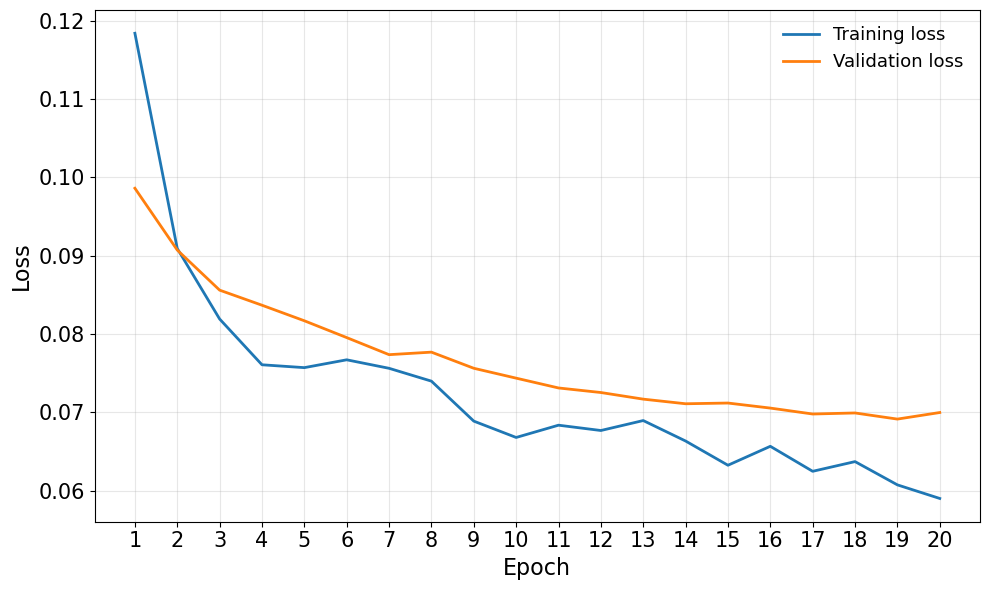

In [4]:
loss, val_loss = df["loss"], df["val_loss"]
mae, val_mae = df["mae"], df["val_mae"]

fig, ax = plt.subplots(figsize=(10, 6))

# Loss subplot
ax.plot(epochs, loss,   lw=2, label="Training loss")
ax.plot(epochs, val_loss,  lw=2, label="Validation loss")
#ax.set_title("MSE Loss (Training vs Validation)", fontsize=15)
ax.set_xlabel("Epoch", fontsize=16)
ax.set_ylabel("Loss", fontsize=16)
ax.set_xticks(np.arange(min(epochs), max(epochs)+1, 1))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(frameon=False, fontsize=13)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## AI vs Stockfish game results (By search depth)

In [5]:
FILE_FORMAT = "arena_results_sf*_ai*.csv"
files = sorted(glob.glob(FILE_FORMAT))
pat = re.compile(r"arena_results_sf(\d+)_ai(\d+)\.csv$", re.I)

In [6]:
results = []
for f in files:
    m = pat.search(os.path.basename(f))
    if not m:
        continue
    sfd, aid = map(int, m.groups())
    df = pd.read_csv(f)
    df["sfd"] = sfd
    df["aid"] = aid
    results.append(df)

if not results:
    raise FileNotFoundError(f"No CSV files matched {FILE_FORMAT}. Assign the correct path to the CSVs.")

results_df = pd.concat(results, ignore_index=True)

In [7]:
res = results_df["result"]
final_outcome = np.where(res == "ai", "Win", np.where(res == "stockfish", "Loss", "Draw"))
results_df["final_outcome"] = final_outcome


In [8]:
counts = (results_df
          .groupby(["aid", "sfd", "final_outcome"])
          .size()
          .unstack("final_outcome", fill_value=0)
          .reset_index())
counts["Games"] = counts[["Win", "Draw", "Loss"]].sum(axis=1)
counts["Score"] = (counts["Win"] + 0.5 * counts["Draw"]) / counts["Games"]
counts["Elo_diff"] = -400.0 * np.log10((1/counts["Score"]) - 1)

In [9]:
results_df

,game_index,ai_color,result,plies,sf_depth,ai_depth,ai_nodes,ai_time_ms,ai_nps,tt_probes,...,history_uses,ai_moves,sf_time_ms,game_wall_ms,did_castle,did_en_passant,did_promotion,sfd,aid,final_outcome
0,1,white,Draw (Three-Fold Repetetion),87,2,2,737,9131.5,81,737,...,85,44,23.4,9184.9,False,False,False,2,2,Draw
1,2,black,stockfish,87,2,2,1150,8292.9,139,1150,...,105,43,23.0,8341.6,False,True,False,2,2,Loss
2,3,white,stockfish,60,2,2,797,5549.1,144,797,...,111,30,15.4,5581.1,True,False,False,2,2,Loss
3,4,black,stockfish,31,2,2,222,1612.9,138,222,...,0,15,7.6,1630.3,False,False,False,2,2,Loss
4,5,white,Draw (Three-Fold Repetetion),99,2,2,1161,8975.4,129,1161,...,183,50,23.6,9028.8,True,False,False,2,2,Draw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,46,black,stockfish,133,4,4,98199,537114.3,183,98199,...,10891,66,146.4,537311.0,True,False,True,4,4,Loss
296,47,white,Draw (Three-Fold Repetetion),100,4,4,67838,461227.5,147,67838,...,6260,50,81.4,461345.8,True,False,False,4,4,Draw
297,48,black,Draw (Three-Fold Repetetion),76,4,4,56592,439641.0,129,56592,...,1986,38,62.9,439736.4,False,False,False,4,4,Draw
298,49,white,Draw (Three-Fold Repetetion),56,4,4,64514,489974.5,132,64514,...,4102,28,44.1,490047.5,False,False,False,4,4,Draw


In [10]:
counts

final_outcome,aid,sfd,Draw,Loss,Win,Games,Score,Elo_diff
0,2,2,28,20,2,50,0.32,-130.943574
1,3,2,32,14,4,50,0.40,-70.436504
2,3,3,24,21,5,50,0.34,-115.226007
3,4,2,40,8,2,50,0.44,-41.894140
4,4,3,39,4,7,50,0.53,20.871205
5,4,4,38,9,3,50,0.44,-41.894140


In [11]:
sel_counts = counts.merge(pd.DataFrame([(2,3),(3,3),(3,4),(4,4)], columns=["sfd","aid"]))
plot_df = sel_counts.sort_values(["sfd", "aid"]).reset_index(drop=True).copy()

x = np.arange(len(plot_df))
labels = [f"AI Depth {int(a)}\nStockfish Depth {int(s)}" for a, s in zip(plot_df["aid"], plot_df["sfd"])]

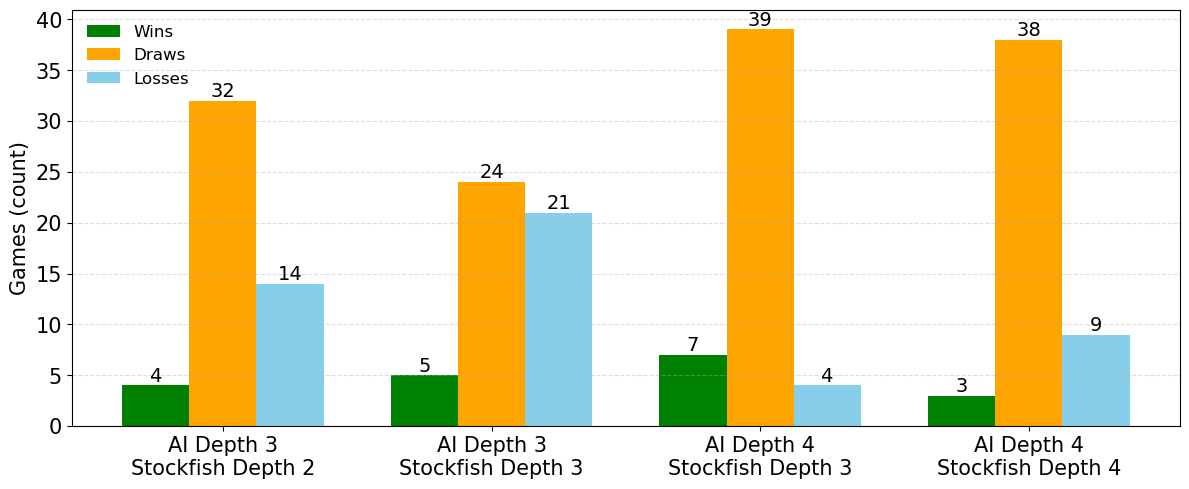

In [12]:
width = 0.25
offsets = (-width, 0.0, width)

color_win  = "navy"
color_draw = "grey"  
color_loss = "lightblue"

fig, ax = plt.subplots(figsize=(12, 5))

b1 = ax.bar(x + offsets[0], plot_df["Win"].values,  width, label="Wins",  color="green")
b2 = ax.bar(x + offsets[1], plot_df["Draw"].values, width, label="Draws", color="orange")
b3 = ax.bar(x + offsets[2], plot_df["Loss"].values, width, label="Losses",color="#87CEEB")
#ax.set_title("Stockfish vs Our AI — Outcomes by Depth Pair (Win/Draw/Loss)", fontsize=15)
ax.set_ylabel("Games (count)", fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(labels, ha="center", fontsize = 16)
ax.legend(frameon=False, fontsize = 12)
ax.grid(axis="y", linestyle="--", alpha=0.4)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

def annotate(bars):
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            ax.text(bar.get_x() + bar.get_width()/2, h, f"{int(h)}",
                    ha="center", va="bottom", fontsize=14)
annotate(b1); annotate(b2); annotate(b3)

plt.tight_layout()
plt.show()

# Descriptive Statistics

In [ ]:
results_df['sf_moves'] = results_df['plies'] - results_df['ai_moves']
results_df['ai_tpm_s'] = (results_df['ai_time_ms']/ results_df['ai_moves'].clip(lower=1)) / 1000.0
results_df['sf_tpm_s'] = (results_df['sf_time_ms']/ results_df['sf_moves'].clip(lower=1)) / 1000.0

metric_selections = [
    'ai_tpm_s', 'sf_tpm_s', 'ai_nps','tt_hits','beta-cutoffs',
    'first_move_cutoff','killer_uses','history_uses'
]

avg_cols = [c for c in metric_selections if c in results_df.columns]
avgs = results_df.groupby(['sfd', 'aid'])[avg_cols].mean().add_prefix('avg_').reset_index()

to_round = [c for c in ['avg_ai_nps','avg_tt_hits','avg_killer_uses','avg_history_uses'] if c in avgs.columns]

for c in to_round:
    avgs[c] = avgs[c].round(0).astype('Int64') 
else:
    avgs[c] = avgs[c].round(4)



summary = (counts.merge(avgs, on=['sfd','aid'], how = 'left')
           .sort_values(['sfd','aid'])
           .reset_index(drop=True)
           .drop(columns = ['Draw', 'Loss', 'Win', 'Games']))

print(summary.to_string(index=False))

 aid  sfd  Score    Elo_diff  avg_ai_tpm_s  avg_sf_tpm_s  avg_ai_nps  avg_tt_hits  avg_killer_uses  avg_history_uses
   2    2   0.32 -130.943574      0.217197      0.000559         127            0              124               125
   3    2   0.40  -70.436504      1.614186      0.000666         122            5              692               699
   4    2   0.44  -41.894140     11.375809      0.001041         144        10184            11260             11666
   3    3   0.34 -115.226007      1.711844      0.000752         116            5              726               737
   4    3   0.53   20.871205      9.703877      0.001238         154        10017            11933             12417
   4    4   0.44  -41.894140     11.045754      0.001595         149         9886             9659             10027
